In [17]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), ".."))

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import v2

import tqdm
import wandb
import matplotlib.pyplot as plt
import numpy as np

from satellite2map.datasets import Maps
from satellite2map.models.generator import UnetGenerator
from satellite2map.models.discriminator import ConditionalDiscriminator
from satellite2map.losses import GeneratorLoss, DiscriminatorLoss
import satellite2map.transforms as T

from dataclasses import dataclass
import time

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CycleGAN implementation

In [18]:
@dataclass
class hyperparameters:
    # training hyperparams
    n_epochs: int = 32
    batch_size: int = 32
    lr: float = 2e-3

hyperparams = hyperparameters()

In [19]:
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="my-awesome-project",

#     # track hyperparameters and run metadata
#     config={
#     "learning_rate": hyperparams.lr,
#     "architecture": "Unet",
#     "dataset": "Maps",
#     "epochs": hyperparams.n_epochs,
#     "batch_size": hyperparams.batch_size,
#     }
# )

## Loading data

In [28]:
transforms = T.Compose([T.Resize((256,256)),
                        T.ToTensor(),
                        T.Normalize(mean=[0.5, 0.5, 0.5],
                                     std=[0.5, 0.5, 0.5])])

train_dataset = Maps(root='../data/raw', mode='train', transform=transforms, download=False)
val_dataset   = Maps(root='../data/raw', mode='val', transform=transforms, download=False)

train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=True)
val_dataloader   = DataLoader(val_dataset,   batch_size=hyperparams.batch_size, shuffle=True)

1 torch.Size([3, 256, 256]) torch.Size([3, 256, 256])
2 torch.Size([3, 256, 256]) torch.Size([3, 256, 256])
3 torch.Size([3, 256, 256]) torch.Size([3, 256, 256])
4 torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


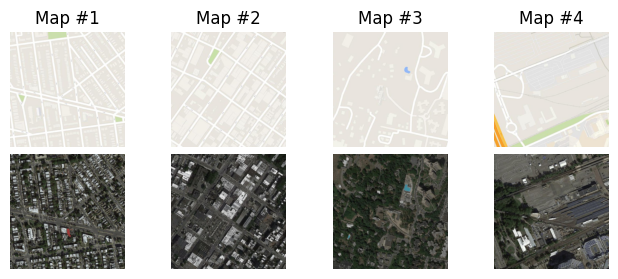

In [41]:
for i, (sat, map) in enumerate(train_dataset):
    i = i + 1
    print(i, sat.shape, map.shape)

    ax = plt.subplot(1, 4, i)
    plt.tight_layout()
    ax.set_title('Satellite #{}'.format(i))
    ax.axis('off')
    sat = sat * 0.5 + 0.5
    plt.imshow(sat.permute((1, 2, 0)).numpy())

    ax = plt.subplot(2, 4, i)
    plt.tight_layout()
    ax.set_title('Map #{}'.format(i))
    ax.axis('off')
    map = map * 0.5 + 0.5
    plt.imshow(map.permute((1, 2, 0)).numpy())

    if i == 4:
        plt.show()
        break

# Preparing for training

In [43]:
generator = UnetGenerator().to(DEVICE)
discriminator = ConditionalDiscriminator().to(DEVICE)

g_criterion = GeneratorLoss()
d_criterion = DiscriminatorLoss()

g_optimizer = torch.optim.Adam(generator.parameters(), lr=hyperparams.lr, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=hyperparams.lr, betas=(0.5, 0.999))

## Training loop

In [ ]:
for epoch in range(hyperparams.n_epochs):
    ge_loss=0.
    de_loss=0.
    start = time.time()
    for x, real in tqdm(train_dataloader):
        x = x.to(DEVICE)
        real = real.to(DEVICE)

        # Generator`s loss
        fake = generator(x)
        fake_pred = discriminator(fake, x)
        g_loss = g_criterion(fake, real, fake_pred)

        # Discriminator`s loss
        fake = generator(x).detach()
        fake_pred = discriminator(fake, x)
        real_pred = discriminator(real, x)
        d_loss = d_criterion(fake_pred, real_pred)

        # Generator`s params update
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Discriminator`s params update
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        # add batch losses
        ge_loss += g_loss.item()
        de_loss += d_loss.item()

    # obtain per epoch losses
    g_loss = ge_loss/len(train_dataloader)
    d_loss = de_loss/len(train_dataloader)
    # count timeframe
    end = time.time()
    tm = (end - start)
    # logging
    wandb.log({"generator_loss": g_loss, "discriminator_loss": d_loss, "time": tm})
    torch.save(generator.state_dict(), f'./models/pix2pix/checkpoints/generator')
    torch.save(discriminator.state_dict(), f'./models/pix2pix/checkpoints/discriminator')
    print(f"[Epoch {epoch+1}/{hyperparams.epochs}] [G loss: {g_loss}] [D loss: {d_loss}] ETA: {tm}")